## conda environments

When accessing this notebook via the JASMIN Jupyter Notebook service, select the correct conda environment from the list of available kernels.

## Imports

In [93]:
import numpy as np
import requests
import pandas as pd
from os import makedirs, path
from tqdm import tqdm

## Code
LAQN class for downloading &  processing of LAQN data. This code is adapted from my [COVID-19 repo](https://github.com/michellewl/COVID-19/blob/master/data/LAQN_class.py) (note that the borough averaging code has not been included here). See [here](https://github.com/michellewl/NO2-breast-cancer/tree/master/data/LAQN/download) for details on the source code (originally written for MRes project).

In [137]:
class LAQNData():
    def __init__(self, url, home_folder, species, start_date, end_date):
        self.url = url
        self.home_folder = home_folder
        self.species = species
        self.start_date = start_date
        self.end_date = end_date
        self.filename = f"{self.species}_hourly_{self.start_date}_{self.end_date}.csv"
        self.filepath = path.join(self.home_folder, self.filename)
        
        if not path.exists(self.home_folder):
            makedirs(self.home_folder)
        
        london_sites = requests.get(self.url)
        self.sites_df = pd.DataFrame(london_sites.json()['Sites']['Site'])
        self.site_codes = self.sites_df["@SiteCode"].tolist()

    def download(self, verbose=True):
        laqn_df = pd.DataFrame()
        
        if verbose:
            progress_bar = tqdm(self.site_codes)
        else:
            progress_bar = self.site_codes
            
        for site_code in progress_bar:
            if verbose:
                progress_bar.set_description(f'Working on site {site_code}')
            url_species = f"http://api.erg.kcl.ac.uk/AirQuality/Data/SiteSpecies/SiteCode={site_code}/SpeciesCode={self.species}/StartDate={self.start_date}/EndDate={self.end_date}/csv"
            cur_df = pd.read_csv(url_species)
            cur_df.columns = ["date", site_code]
            cur_df.set_index("date", drop=True, inplace=True)

            try:
                if laqn_df.empty:
                    laqn_df = cur_df.copy()
                else:
                    laqn_df = laqn_df.join(cur_df.copy(), how="outer")

            except ValueError:  # Trying to join with duplicate column names
                rename_dict = {}
                for x in list(set(cur_df.columns).intersection(laqn_df.columns)):
                    rename_dict.update({x: f"{x}_"})
                    print(f"Renamed duplicated column:\n{rename_dict}")
                laqn_df.rename(mapper=rename_dict, axis="columns", inplace=True)
                if laqn_df.empty:
                    laqn_df = cur_df.copy()
                else:
                    laqn_df = laqn_df.join(cur_df.copy(), how="outer")
                if verbose:
                    print(f"Joined.")

            except KeyError:  # Trying to join along indexes that don't match
                print(f"Troubleshooting {site_code}...")
                cur_df.index = cur_df.index + ":00"
                if laqn_df.empty:
                    laqn_df = cur_df.copy()
                else:
                    laqn_df = laqn_df.join(cur_df.copy(), how="outer")
                print(f"{site_code} joined.")

        print("Data download complete. Removing sites with 0 data...")
        laqn_df.dropna(axis="columns", how="all", inplace=True)
        laqn_df.to_csv(path.join(self.home_folder, self.filename))
        print("Data saved.")

    def read_csv(self, verbose=True):
        if verbose:
            print(f"Reading {self.filename}...")
        return pd.read_csv(self.filepath, index_col="date", parse_dates=True)
    
    def resample_time(self, df, key, quantile_step, verbose=True):
        if key == "D":
            keyword = "daily"
        if key == "W":
            keyword = "weekly"

        save_folder = path.join(self.home_folder, keyword)
        if not path.exists(save_folder):
            makedirs(save_folder)

        aggregation = np.round(np.arange(0, 1 + quantile_step, quantile_step), 2).tolist()

        for method in aggregation:
            aggregated_df = df.copy().resample(key).quantile(method)
            method = f"{int(method * 100)}th_quantile"
            aggregated_df.to_csv(path.join(save_folder, f"{self.species}_{keyword}_{method}.csv"), index=True)
            if verbose:
                print(f"Dataframe shape {aggregated_df.shape}")
        if verbose:
            print("Done.")

In [138]:
home_folder = path.join(path.abspath(""), "LAQN_data")
species = "NO2"
url = "http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json"
start_date = "2000-01-01"
end_date = "2021-01-01"

In [139]:
NO2_hourly = LAQNData(url, home_folder, species, start_date, end_date)

In [88]:
print(len(NO2_hourly.site_codes))

236


### Download the LAQN NO$_2$ data

In [75]:
NO2_hourly.download()

Working on site VS1: 100%|██████████| 236/236 [29:31<00:00,  7.51s/it]


Data download complete. Removing sites with 0 data...
Data saved.


### Load the NO$_2$ data and aggregate to weekly time steps

In [140]:
hourly_df = NO2_hourly.read_csv()

Reading NO2_hourly_2000-01-01_2021-01-01.csv...


Now we choose a temporal resolution (key) and size of quantile steps to aggregate the data over.
For example, `key="W", quantile_step=0.25` produces 4 .csv files, each containing a 25th percentile of the data distribution at weekly scale. Spatial resolution is retained i.e. still contains data for all sites.

In [141]:
NO2_hourly.resample_time(hourly_df, "W", 0.25)

Dataframe shape (1097, 192)
Dataframe shape (1097, 192)
Dataframe shape (1097, 192)
Dataframe shape (1097, 192)
Dataframe shape (1097, 192)
Done.


### Load the median weekly NO$_2$ data and plot

In [142]:
median_filepath = path.join(NO2_hourly.home_folder, "weekly/NO2_weekly_50th_quantile.csv")
median_df = pd.read_csv(median_filepath, index_col="date", parse_dates=True)

In [143]:
median_df.head()

,TD0,BG3,BG1,BG2,BN2,BN3,BN1,BX5,BX2,BQ7,...,WMD,WM0,MY1,WM6,WMZ,WMB,NB1,WM8,WM9,VS1
date,,,,,,,,,,,,,,,,,,,,,
2000-01-02,21.2,NaN,NaN,NaN,NaN,NaN,38.65,24.55,27.30,NaN,...,NaN,NaN,81.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-09,20.6,NaN,NaN,NaN,NaN,NaN,64.10,27.40,28.55,NaN,...,NaN,NaN,93.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-16,40.5,NaN,NaN,NaN,NaN,NaN,60.35,30.50,33.65,NaN,...,NaN,NaN,72.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-23,52.6,NaN,NaN,NaN,NaN,NaN,50.05,46.15,53.00,NaN,...,NaN,NaN,68.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-30,47.6,NaN,NaN,NaN,NaN,NaN,90.15,48.30,56.10,NaN,...,NaN,NaN,98.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='date'>

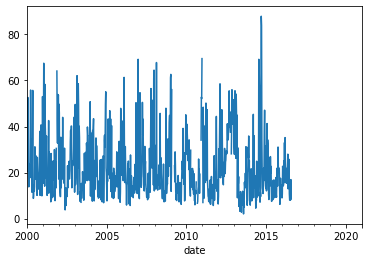

In [150]:
median_df["TD0"].plot()